<a href="https://colab.research.google.com/github/currencyfxjle/NapoleonVersions_tradelocker/blob/main/Napoleon_Versions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

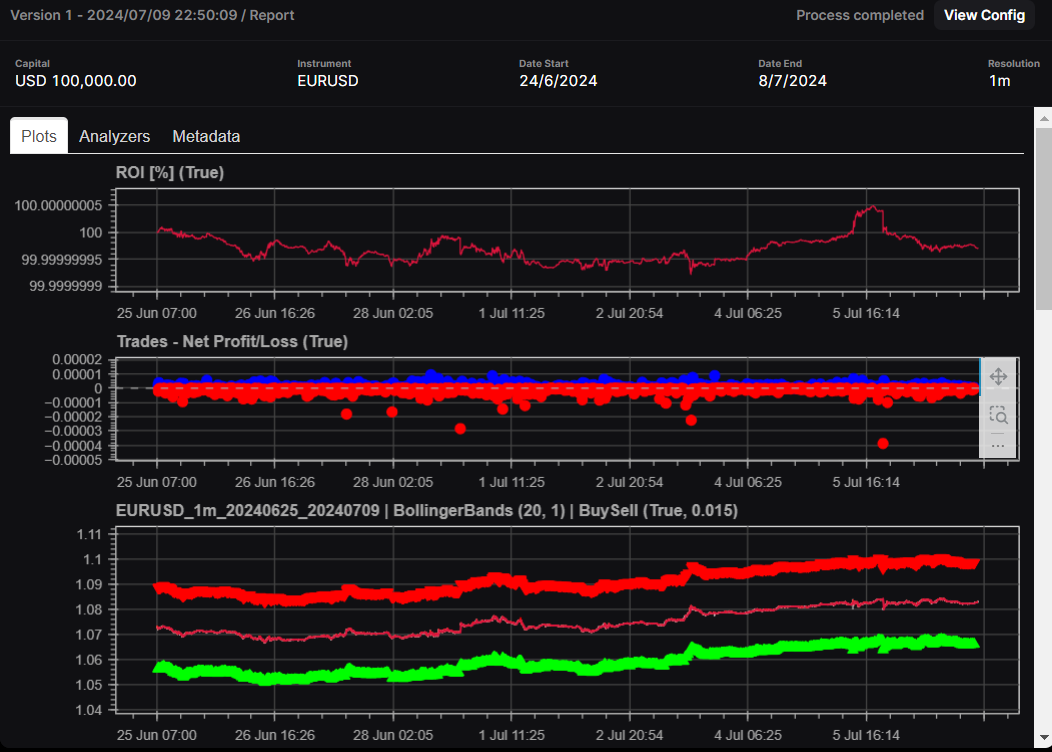

In [ ]:
import backtrader as bt

class NapoleonEA(bt.Strategy):
    params = (
        ('initial_lot_size', 0.01),
        ('tp_in_pips', 5),
        ('multiplier', 1.05),
        ('max_lot_size', 7),
        ('daily_sl', 1),
        ('grid_size', 0),
        ('bb_period', 30),
        ('bb_devfactor', 1),
        ('max_spread', 10),
        ('_Point', 0.00001),
        ('hidden_tp_pips', 10),
        ('max_daily_loss', 100),
        ('max_monthly_profit', 500),
        ('close_on_drawdown_percent', 5),
        ('trailing_stop', 2),
        ('atr_period', 14),
        ('max_daily_profit', 200),  # Maximum daily profit
        ('romad_threshold', 2.0),  # ROMAD threshold for increasing the multiplier
        ('rf_threshold', 1.0),  # RF threshold for increasing the multiplier
        ('max_multiplier', 2.0),  # Maximum allowable multiplier
    )

    def __init__(self):
        self.order = None
        self.open_trades = {}
        self.order_ref_to_trade_id = {}
        self.bbands = bt.indicators.BollingerBands(period=self.params.bb_period, devfactor=self.params.bb_devfactor)
        self.realized_daily_profit = 0
        self.realized_monthly_profit = 0
        self.last_check_date = self.data.datetime.datetime(0).date()
        self.highest_account_balance = self.broker.getvalue()  # Track the highest account balance
        self.lot_multiplier = self.params.multiplier
        self.equity_curve = []
        self.max_drawdown = 0

    def notify_order(self, order):
        if order.status in [bt.Order.Completed]:
            trade_id = self.order_ref_to_trade_id[order.ref]
            if trade_id in self.open_trades:
                self.log(f'Order executed: {order.ref}, Price: {order.executed.price}')
        elif order.status in [bt.Order.Canceled, bt.Order.Margin, bt.Order.Rejected]:
            self.log(f'Order Canceled/Margin/Rejected: {order.ref}')
            if order.ref in self.order_ref_to_trade_id:
                trade_id = self.order_ref_to_trade_id[order.ref]
                if trade_id in self.open_trades:
                    del self.open_trades[trade_id]
                del self.order_ref_to_trade_id[order.ref]

    def notify_trade(self, trade):
        if trade.isclosed:
            trade_ids_to_remove = []
            for order_ref, trade_id in self.order_ref_to_trade_id.items():
                if trade_id in self.open_trades:
                    del self.open_trades[trade_id]
                    trade_ids_to_remove.append(order_ref)
                    self.log(f'Trade: {trade_id}')
            for order_ref in trade_ids_to_remove:
                del self.order_ref_to_trade_id[order_ref]
            profit = trade.pnlcomm
            self.realized_daily_profit += profit
            self.realized_monthly_profit += profit

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()}, {txt}')

    def next(self):
        self.manage_drawdown()  # Manage ongoing drawdown based on account value
        self.check_daily_limits()  # Check and handle daily profit/loss limits
        self.update_equity_curve()  # Update equity curve for drawdown calculations
        self.adjust_lot_multiplier()  # Adjust the lot size multiplier based on performance

        # Execute trading signals
        self.execute_trading_signals()

    def execute_trading_signals(self):
        # This method encapsulates your trading signals execution logic
        if self.get_total_buy_orders_count() == 0 and (self.check_buy_signal_trend() or self.check_buy_signal_counter()):
            # Calculate the take profit price for a buy order
            tp_price = self.data.close[0] + (self.params.tp_in_pips * self.params._Point * 10)
            # Open a buy market trade with the initial lot size and calculated take profit price
            self.order = self.open_market_trade(self.params.initial_lot_size, tp_price)

        if self.get_total_sell_orders_count() == 0 and (self.check_sell_signal_trend() or self.check_sell_signal_counter()):
            # Calculate the take profit price for a sell order
            tp_price = self.data.close[0] - (self.params.tp_in_pips * self.params._Point * 10)
            # Open a sell market trade with the initial lot size and calculated take profit price
            self.order = self.open_market_trade(-self.params.initial_lot_size, tp_price)

        # Logic to handle additional buy orders under certain conditions
        if (self.get_total_buy_orders_count() > 0
            and self.order.ref in self.open_trades
            and self.open_trades[self.order.ref]['open_time'] != self.data.close[-1]
            and self.data.close[-1] < self.position.price):
            lots = self.lot_multiplier
            if lots > self.params.max_lot_size:
                lots = self.params.max_lot_size

            tp_price = self.data.close[0] + (self.params.tp_in_pips * self.params._Point * 10)

            if (self.params.grid_size > 0
                and (self.data.close[0] - self.data.ask[0]) > (self.params.grid_size * self.params._Point * 10)):
                self.order = self.open_market_trade(lots, tp_price)
            elif self.params.grid_size == 0:
                self.order = self.open_market_trade(lots, tp_price)

        if (self.get_total_sell_orders_count() > 0
            and self.order.ref in self.open_trades
            and self.open_trades[self.order.ref]['open_time'] != self.data.close[-1]
            and self.data.close[-1] > self.position.price):
            lots = self.lot_multiplier
            if lots > self.params.max_lot_size:
                lots = self.params.max_lot_size

            tp_price = self.data.close[0] - (self.params.tp_in_pips * self.params._Point * 10)

            if (self.params.grid_size > 0
                and (self.data.close[0] - self.data.ask[0]) > (self.params.grid_size * self.params._Point * 10)):
                self.order = self.open_market_trade(-lots, tp_price)
            elif self.params.grid_size == 0:
                self.order = self.open_market_trade(-lots, tp_price)

    def open_market_trade(self, lots, tp_price):
        order = self.buy(size=lots, exectype=bt.Order.Market) if lots > 0 else self.sell(size=-lots, exectype=bt.Order.Market)
        trade_id = f"{order.ref}_{self.data.datetime.date(0)}"
        self.order_ref_to_trade_id[order.ref] = trade_id
        self.open_trades[trade_id] = {
            'price': order.executed.price,
            'size': abs(lots),
            'type': 'buy' if lots > 0 else 'sell',
            'open_time': self.data.num2date(order.executed.dt),
            'tp_price': tp_price
        }
        return order

    def check_take_profit(self):
        for order_ref, details in list(self.open_trades.items()):  # Iterate over a copy to modify dict
            if self.data.close[0] >= details['tp_price']:
                self.sell(size=details['size'])
                del self.open_trades[order_ref]
                self.log(f'Take profit executed: {order_ref} at price {self.data.close[0]}')

    def check_buy_signal_trend(self):
        return (self.data.close[-2] < self.bbands.lines.top[-2] and
                self.data.close[-1] < self.bbands.lines.top[-1] and
                self.data.close[-1] > self.data.open[-1])

    def check_buy_signal_counter(self):
        return ((self.data.close[-2] > self.bbands.lines.bot[-2] and
                 self.data.close[-1] < self.bbands.lines.bot[-1]) or
                (self.data.close[-1] < self.bbands.lines.bot[-1] and
                 self.data.close[-1] > self.data.low[-1]))

    def check_sell_signal_trend(self):
        return (self.data.close[-2] > self.bbands.lines.bot[-2] and
                self.data.close[-1] > self.bbands.lines.bot[-1] and
                self.data.close[-1] < self.data.open[-1])

    def check_sell_signal_counter(self):
        return ((self.data.close[-2] < self.bbands.lines.top[-2] and
                 self.data.close[-1] > self.bbands.lines.top[-1]) or
                (self.data.close[-1] > self.bbands.lines.top[-1] and
                 self.data.close[-1] < self.data.high[-1]))

    def get_average_buy_entry_price(self):
        total_cost = sum(trade['price'] * trade['size'] for trade_id, trade in self.open_trades.items() if trade['type'] == 'buy')
        total_size = sum(trade['size'] for trade_id, trade in self.open_trades.items() if trade['type'] == 'buy')
        return total_cost / total_size if total_size else 0

    def get_average_sell_entry_price(self):
        total_cost = sum(trade['price'] * trade['size'] for trade_id, trade in self.open_trades.items() if trade['type'] == 'sell')
        total_size = sum(trade['size'] for trade_id, trade in self.open_trades.items() if trade['type'] == 'sell')
        return total_cost / total_size if total_size else 0

    def get_total_buy_orders_count(self):
        return sum(1 for trade_id, trade in self.open_trades.items() if trade['type'] == 'buy')

    def get_total_sell_orders_count(self):
        return sum(1 for trade_id, trade in self.open_trades.items() if trade['type'] == 'sell')

    def get_unrealized_pnl(self):
        if not self.position:
            return 0
        buy_avg_price = self.position.price
        current_price = self.data.close[0]
        position_size = self.position.size
        unrealized_pnl = (current_price - buy_avg_price) * position_size
        normalized_unrealized_pnl = round(unrealized_pnl, 2)
        return normalized_unrealized_pnl

    def modify_tp_for_buy_trades(self, tp_price):
        current_price = self.data.close[0]
        for order_ref, trade_id in self.order_ref_to_trade_id.items():
            trade_type = self.open_trades[trade_id]['type']
            tp_price = self.open_trades[trade_id]['tp_price']
            if trade_type == 'buy' and current_price >= tp_price:
                self.close(self.open_trades[trade_id]['size'])

    def modify_tp_for_sell_trades(self, tp_price):
        current_price = self.data.close[0]
        for order_ref, trade_id in self.order_ref_to_trade_id.items():
            trade_type = self.open_trades[trade_id]['type']
            tp_price = self.open_trades[trade_id]['tp_price']
            if trade_type == 'sell' and current_price <= tp_price:
                self.close(self.open_trades[trade_id]['size'])

    def manage_drawdown(self):
        current_balance = self.broker.getvalue()
        if (current_balance > self.highest_account_balance):
            self.highest_account_balance = current_balance
        drawdown = (self.highest_account_balance - current_balance) / self.highest_account_balance * 100
        if drawdown > self.params.close_on_drawdown_percent:
            self.log(f'Drawdown exceeded {self.params.close_on_drawdown_percent}%, closing all trades.')
            self.close_all_trades()

    def close_all_trades(self):
        for trade_id in list(self.open_trades.keys()):
            self.close(self.open_trades[trade_id]['size'])
            self.log('All positions closed due to drawdown.')

    def check_daily_limits(self):
        if abs(self.realized_daily_profit) > self.params.max_daily_loss:
            self.log('Daily loss limit exceeded, all trades closed.')
            self.close_all_trades()
        elif self.realized_daily_profit > self.params.max_daily_profit:
            self.log('Daily profit target achieved, all trades closed.')
            self.close_all_trades()

    def adjust_lot_multiplier(self):
        romad = self.calculate_romad()
        rf = self.calculate_rf()
        if romad > self.params.romad_threshold and rf > self.params.rf_threshold:
            self.lot_multiplier = min(self.lot_multiplier * self.params.multiplier, self.params.max_multiplier)
        else:
            self.lot_multiplier = self.params.multiplier

    def calculate_romad(self):
        net_profit = self.realized_monthly_profit
        max_drawdown = self.max_drawdown
        if max_drawdown == 0:
            return 0
        romad = net_profit / max_drawdown
        return round(romad, 2)

    def calculate_rf(self):
        net_profit = self.realized_monthly_profit
        max_drawdown = self.max_drawdown
        if max_drawdown == 0:
            return 0
        rf = net_profit / abs(max_drawdown)
        return round(rf, 2)

    def update_equity_curve(self):
        current_balance = self.broker.getvalue()
        self.equity_curve.append(current_balance)
        peak = max(self.equity_curve, default=current_balance)
        drawdown = (peak - current_balance) / peak
        self.max_drawdown = max(self.max_drawdown, drawdown)

    def next(self):
        self.manage_drawdown()  # Manage ongoing drawdown based on account value
        self.check_daily_limits()  # Check and handle daily profit/loss limits
        self.update_equity_curve()  # Update equity curve for drawdown calculations
        self.adjust_lot_multiplier()  # Adjust the lot size multiplier based on performance

        # Execute trading signals
        self.execute_trading_signals()

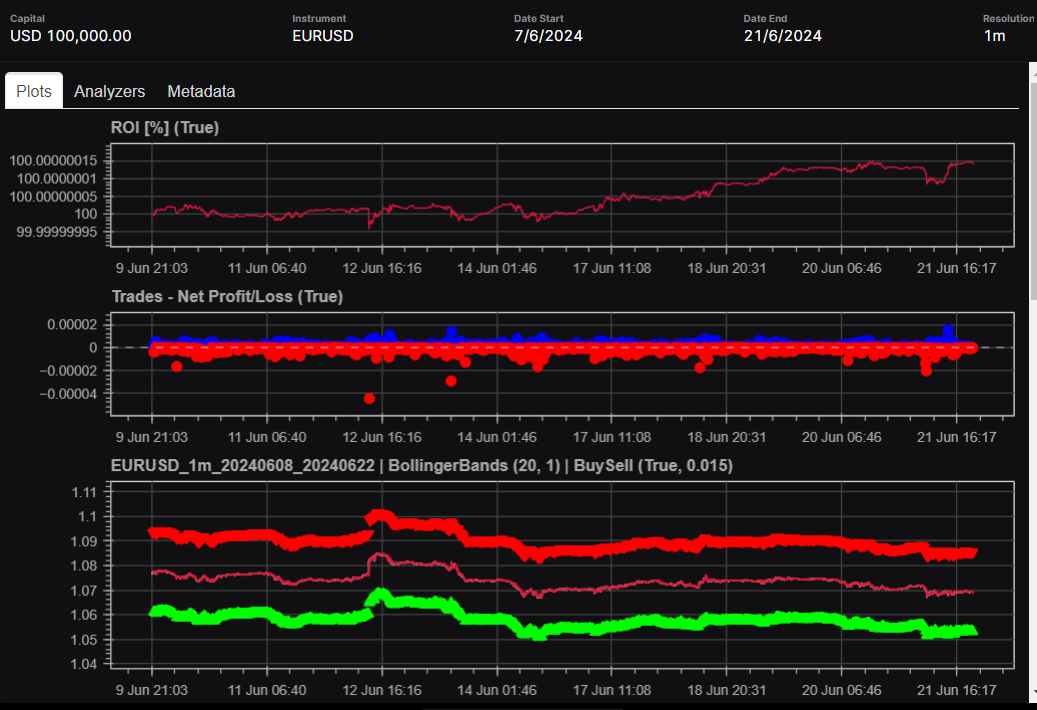

In [ ]:
import backtrader as bt

class NapoleonEA(bt.Strategy):
    params = (
        ('initial_lot_size', 0.01),
        ('tp_in_pips', 5),
        ('bb_period', 20),
        ('bb_devfactor', 1),
        ('max_daily_loss', 100),
        ('close_on_drawdown_percent', 5),
        ('max_daily_profit', 200),
        ('daily_sl', 1),
        ('_Point', 0.00001),  # Adding the _Point parameter
    )

    def __init__(self):
        self.order = None
        self.bbands = bt.indicators.BollingerBands(period=self.params.bb_period, devfactor=self.params.bb_devfactor)
        self.highest_account_balance = self.broker.getvalue()
        self.starting_balance = self.broker.getvalue()
        self.realized_daily_profit = 0

    def notify_order(self, order):
        if order.status in [bt.Order.Completed]:
            self.log(f'Order executed: {order.ref}, Price: {order.executed.price}')
        elif order.status in [bt.Order.Canceled, bt.Order.Margin, bt.Order.Rejected]:
            self.log(f'Order Canceled/Margin/Rejected: {order.ref}')

    def notify_trade(self, trade):
        if trade.isclosed:
            self.log(f'Trade closed: PnL: {trade.pnlcomm}')
            self.realized_daily_profit += trade.pnlcomm

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()}, {txt}')

    def next(self):
        self.manage_drawdown()
        self.check_daily_limits()
        self.execute_trading_signals()

    def execute_trading_signals(self):
        if not self.position:
            if self.check_buy_signal_trend() or self.check_buy_signal_counter():
                tp_price = self.data.close[0] + (self.params.tp_in_pips * self.params._Point * 10)
                self.order = self.buy(size=self.params.initial_lot_size)
                self.log(f'Buy order placed, TP: {tp_price}')
            elif self.check_sell_signal_trend() or self.check_sell_signal_counter():
                tp_price = self.data.close[0] - (self.params.tp_in_pips * self.params._Point * 10)
                self.order = self.sell(size=self.params.initial_lot_size)
                self.log(f'Sell order placed, TP: {tp_price}')
        else:
            if self.position.size > 0 and (self.check_sell_signal_trend() or self.check_sell_signal_counter()):
                self.close()
                self.log('Buy position closed due to sell signal')
            elif self.position.size < 0 and (self.check_buy_signal_trend() or self.check_buy_signal_counter()):
                self.close()
                self.log('Sell position closed due to buy signal')

    def check_buy_signal_trend(self):
        return (self.data.close[-2] < self.bbands.lines.top[-2] and
                self.data.close[-1] < self.bbands.lines.top[-1] and
                self.data.close[-1] > self.data.open[-1])

    def check_buy_signal_counter(self):
        return ((self.data.close[-2] > self.bbands.lines.bot[-2] and
                 self.data.close[-1] < self.bbands.lines.bot[-1]) or
                (self.data.close[-1] < self.bbands.lines.bot[-1] and
                 self.data.close[-1] > self.data.low[-1]))

    def check_sell_signal_trend(self):
        return (self.data.close[-2] > self.bbands.lines.bot[-2] and
                self.data.close[-1] > self.bbands.lines.bot[-1] and
                self.data.close[-1] < self.data.open[-1])

    def check_sell_signal_counter(self):
        return ((self.data.close[-2] < self.bbands.lines.top[-2] and
                 self.data.close[-1] > self.bbands.lines.top[-1]) or
                (self.data.close[-1] > self.bbands.lines.top[-1] and
                 self.data.close[-1] < self.data.high[-1]))

    def manage_drawdown(self):
        current_balance = self.broker.getvalue()
        if current_balance > self.highest_account_balance:
            self.highest_account_balance = current_balance
        drawdown = (self.highest_account_balance - current_balance) / self.highest_account_balance * 100
        if drawdown > self.params.close_on_drawdown_percent:
            self.log(f'Drawdown exceeded {self.params.close_on_drawdown_percent}%, closing all trades.')
            self.close_all_trades()

    def close_all_trades(self):
        self.close()
        self.log('All positions closed due to drawdown.')

    def check_daily_limits(self):
        current_balance = self.broker.getvalue()
        daily_loss = self.starting_balance - current_balance
        if daily_loss > self.params.max_daily_loss:
            self.log(f'Daily loss limit exceeded: {daily_loss} > {self.params.max_daily_loss}, all trades closed.')
            self.close_all_trades()
        elif self.realized_daily_profit > self.params.max_daily_profit:
            self.log('Daily profit target achieved, all trades closed.')
            self.close_all_trades()

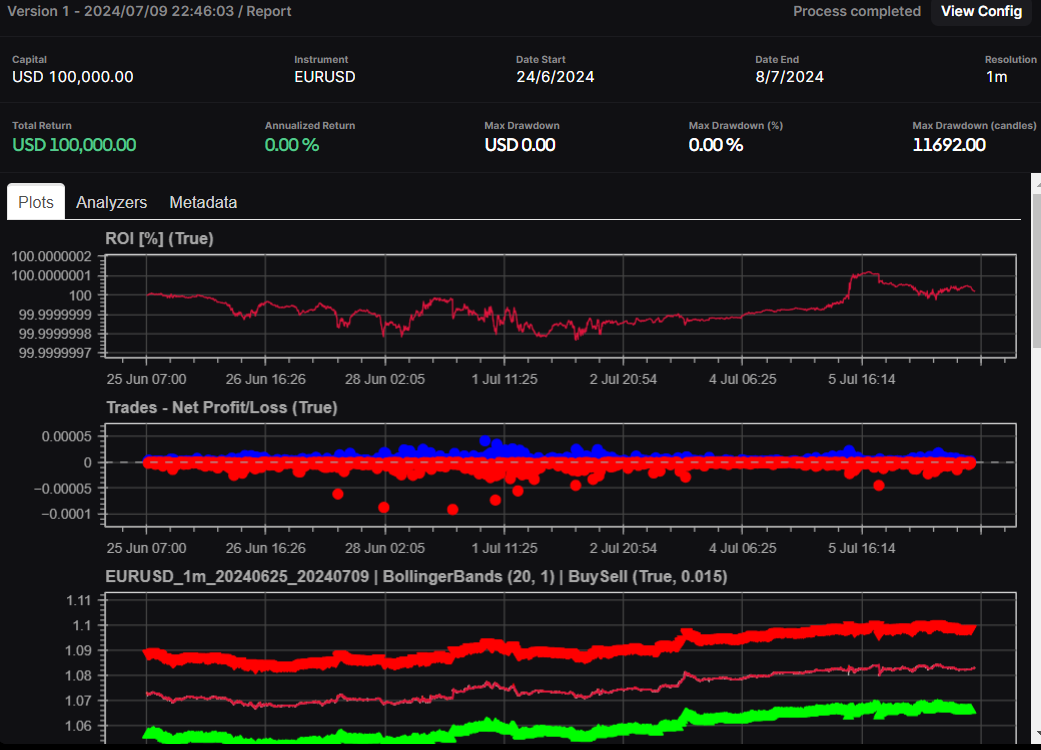

In [ ]:
import backtrader as bt
import pandas as pd
import json

class NapoleonEA(bt.Strategy):
    params = (
        ('initial_lot_size', 0.01),
        ('tp_in_pips', 5),
        ('multiplier', 1.05),
        ('max_lot_size', 7),
        ('bb_period', 20),
        ('bb_devfactor', 1),
        ('max_spread', 10),
        ('_Point', 0.00001),
        ('max_daily_loss', 100),
        ('max_monthly_profit', 500),
        ('close_on_drawdown_percent', 5),
        ('max_daily_profit', 200),
        ('daily_sl', 1),
        ('partial_profit_pct', 50),
        ('partial_profit_distance_pct', 30),
    )

    def __init__(self):
        self.order = None
        self.open_trades = {}
        self.order_ref_to_trade_id = {}
        self.bbands = bt.indicators.BollingerBands(period=self.params.bb_period, devfactor=self.params.bb_devfactor)
        self.realized_daily_profit = 0
        self.realized_monthly_profit = 0
        self.last_check_date = self.data.datetime.datetime(0).date()
        self.highest_account_balance = self.broker.getvalue()
        self.lot_multiplier = self.params.multiplier
        self.equity_curve = []
        self.max_drawdown = 0
        self.starting_balance = self.broker.getvalue()
        self.winning_streak = 0
        self.losing_streak = 0
        self.current_lot_size = self.params.initial_lot_size

    def notify_order(self, order):
        if order.status in [bt.Order.Completed]:
            trade_id = self.order_ref_to_trade_id[order.ref]
            if trade_id in self.open_trades:
                self.log(f'Order executed: {order.ref}, Price: {order.executed.price}')
        elif order.status in [bt.Order.Canceled, bt.Order.Margin, bt.Order.Rejected]:
            self.log(f'Order Canceled/Margin/Rejected: {order.ref}')
            if order.ref in self.order_ref_to_trade_id:
                trade_id = self.order_ref_to_trade_id[order.ref]
                if trade_id in self.open_trades:
                    del self.open_trades[trade_id]
                del self.order_ref_to_trade_id[order.ref]

    def notify_trade(self, trade):
        if trade.isclosed:
            trade_ids_to_remove = []
            for order_ref, trade_id in self.order_ref_to_trade_id.items():
                if trade_id in self.open_trades:
                    del self.open_trades[trade_id]
                    trade_ids_to_remove.append(order_ref)
                    self.log(f'Trade: {trade_id}')
            for order_ref in trade_ids_to_remove:
                del self.order_ref_to_trade_id[order_ref]
            profit = trade.pnlcomm
            self.realized_daily_profit += profit
            self.realized_monthly_profit += profit
            if profit > 0:
                self.winning_streak += 1
                self.losing_streak = 0
            else:
                self.losing_streak += 1
                self.winning_streak = 0
            self.adjust_lot_size()

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()}, {txt}')

    def next(self):
        self.manage_drawdown()
        self.check_daily_limits()
        self.update_equity_curve()
        self.execute_trading_signals()

    def execute_trading_signals(self):
        if self.get_total_buy_orders_count() == 0 and (self.check_buy_signal_trend() or self.check_buy_signal_counter()):
            tp_price_full = self.data.close[0] + (self.params.tp_in_pips * self.params._Point * 10)
            tp_price_partial = self.data.close[0] + (self.params.tp_in_pips * self.params.partial_profit_distance_pct / 100 * self.params._Point * 10)
            self.order = self.open_market_trade(self.current_lot_size, tp_price_partial, tp_price_full)
        if self.get_total_sell_orders_count() == 0 and (self.check_sell_signal_trend() or self.check_sell_signal_counter()):
            tp_price_full = self.data.close[0] - (self.params.tp_in_pips * self.params._Point * 10)
            tp_price_partial = self.data.close[0] - (self.params.tp_in_pips * self.params.partial_profit_distance_pct / 100 * self.params._Point * 10)
            self.order = self.open_market_trade(-self.current_lot_size, tp_price_partial, tp_price_full)

    def open_market_trade(self, lots, tp_price_partial, tp_price_full):
        order = self.buy(size=lots, exectype=bt.Order.Market) if lots > 0 else self.sell(size=-lots, exectype=bt.Order.Market)
        trade_id = f"{order.ref}_{self.data.datetime.date(0)}"
        self.order_ref_to_trade_id[order.ref] = trade_id
        self.open_trades[trade_id] = {
            'price': order.executed.price,
            'size': abs(lots),
            'type': 'buy' if lots > 0 else 'sell',
            'open_time': self.data.num2date(order.executed.dt),
            'tp_price_partial': tp_price_partial,
            'tp_price_full': tp_price_full
        }
        return order

    def check_buy_signal_trend(self):
        return (self.data.close[-2] < self.bbands.lines.top[-2] and
                self.data.close[-1] < self.bbands.lines.top[-1] and
                self.data.close[-1] > self.data.open[-1])

    def check_buy_signal_counter(self):
        return ((self.data.close[-2] > self.bbands.lines.bot[-2] and
                 self.data.close[-1] < self.bbands.lines.bot[-1]) or
                (self.data.close[-1] < self.bbands.lines.bot[-1] and
                 self.data.close[-1] > self.data.low[-1]))

    def check_sell_signal_trend(self):
        return (self.data.close[-2] > self.bbands.lines.bot[-2] and
                self.data.close[-1] > self.bbands.lines.bot[-1] and
                self.data.close[-1] < self.data.open[-1])

    def check_sell_signal_counter(self):
        return ((self.data.close[-2] < self.bbands.lines.top[-2] and
                 self.data.close[-1] > self.bbands.lines.top[-1]) or
                (self.data.close[-1] > self.bbands.lines.top[-1] and
                 self.data.close[-1] < self.data.high[-1]))

    def manage_drawdown(self):
        current_balance = self.broker.getvalue()
        if current_balance > self.highest_account_balance:
            self.highest_account_balance = current_balance
        drawdown = (self.highest_account_balance - current_balance) / self.highest_account_balance * 100
        if drawdown > self.params.close_on_drawdown_percent:
            self.log(f'Drawdown exceeded {self.params.close_on_drawdown_percent}%, closing all trades.')
            self.close_all_trades()

    def close_all_trades(self):
        for trade_id in list(self.open_trades.keys()):
            self.close(self.open_trades[trade_id]['size'])
            self.log('All positions closed due to drawdown.')

    def check_daily_limits(self):
        daily_loss_limit = self.starting_balance * (self.params.daily_sl / 100)
        current_balance = self.broker.getvalue()
        daily_loss = self.starting_balance - current_balance
        if daily_loss > daily_loss_limit:
            self.log(f'Daily loss limit exceeded: {daily_loss} > {daily_loss_limit}, all trades closed.')
            self.close_all_trades()
        elif self.realized_daily_profit > self.params.max_daily_profit:
            self.log('Daily profit target achieved, all trades closed.')
            self.close_all_trades()

    def adjust_lot_size(self):
        if self.winning_streak > 0:
            self.current_lot_size = max(self.params.initial_lot_size, self.current_lot_size / self.params.multiplier)
        elif self.losing_streak > 0:
            self.current_lot_size = min(self.params.max_lot_size, self.current_lot_size * self.params.multiplier)

    def update_equity_curve(self):
        current_balance = self.broker.getvalue()
        self.equity_curve.append(current_balance)
        peak = max(self.equity_curve, default=current_balance)
        drawdown = (peak - current_balance) / peak
        self.max_drawdown = max(self.max_drawdown, drawdown)

    def get_total_buy_orders_count(self):
        return sum(1 for trade_id, trade in self.open_trades.items() if trade['type'] == 'buy')

    def get_total_sell_orders_count(self):
        return sum(1 for trade_id, trade in self.open_trades.items() if trade['type'] == 'sell')